In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install git+https://github.com/mwaskom/seaborn.git

  Preparing metadata (setup.py) ... done
  Cloning https://github.com/mwaskom/seaborn.git to /tmp/pip-req-build-fe98_dji
  Running command git clone --filter=blob:none --quiet https://github.com/mwaskom/seaborn.git /tmp/pip-req-build-fe98_dji
  Resolved https://github.com/mwaskom/seaborn.git to commit 54aeb181a1aae54f8bba1c5c79604783956dc198
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seaborn: filename=seaborn-0.13.0.dev0-py3-none-any.whl size=292588 sha256=9e36add8cc2756e7bbad9fea3fc9f5de866aabf345c2e16ad45f95da12717a2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-klhxsaek/wheels/3c/62/67/77ea88d32d3804d549b08f4c1e9cd0bcfbf53c42cd6b0f8f03
Successfully built seaborn
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
import sys
import json
import pandas as pd
import numpyro
import arviz as az

sys.path.append('drive/MyDrive/user-mod-alignment/policy_analysis/preprocessing/')
sys.path.append('drive/MyDrive/user-mod-alignment/policy_analysis/viz/')
sys.path.append('drive/MyDrive/user-mod-alignment/policy_analysis/models/')

Mounted at /content/drive/


#Preprocessing Data#

#### Load in survey response data from abstract.json. This includes adjustment variables for MRP. **Copy the user-mod-alignment folder into your Google drive for the code to work as written!**  ####



In [ ]:
from preprocess_support import load_support

response_df, participation_df = load_support("/content/drive/My Drive/user-mod-alignment/abstract.json")

# MRP Adjusted Policy-Support Model #

#### This model is described in section 4.3.2 and A2 of the main paper. ####

In [ ]:
from support_adj import run_model

cor_model, means, stds = run_model(participation_df, response_df)

/content/drive/MyDrive/user-mod-alignment/policy_analysis/models/support_adj.py:184: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  cor_model = MCMC(NUTS(mrp_agreement_scraped_only, target_accept_prob=.8), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s, 127 steps of size 2.81e-02. acc. prob=0.93]


In [ ]:
inf_data = az.from_numpyro(cor_model)

In [ ]:
pd.options.display.max_rows = 4000
print(az.summary(inf_data, var_names=["base_slope",
                                      "com_gen_slope", "com_sub_slope", "rem_sub_slope", "rem_gen_slope",
                                      "age_slope", "mod_slope_0", "mod_slope_1"]))


                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
base_slope[0]      1.102  0.892  -0.628    2.736      0.016    0.011   
base_slope[1]      0.769  0.853  -0.780    2.457      0.015    0.010   
base_slope[2]      0.445  0.885  -1.228    2.080      0.016    0.011   
base_slope[3]      1.050  0.869  -0.640    2.643      0.015    0.011   
base_slope[4]      0.759  0.856  -0.841    2.358      0.015    0.010   
com_gen_slope[0]   0.053  0.062  -0.058    0.172      0.001    0.001   
com_gen_slope[1]   0.012  0.053  -0.092    0.112      0.001    0.000   
com_gen_slope[2]   0.022  0.052  -0.080    0.118      0.001    0.000   
com_gen_slope[3]   0.047  0.061  -0.064    0.169      0.001    0.001   
com_gen_slope[4]  -0.023  0.060  -0.136    0.083      0.001    0.001   
com_sub_slope[0]   0.169  0.052   0.075    0.277      0.001    0.000   
com_sub_slope[1]   0.161  0.048   0.066    0.249      0.000    0.000   
com_sub_slope[2]   0.172  0.048   0.080    0.260      0.000    0

# Post-stratification #

### Applies fitted model to target population we want to generalize to in order to correct for response bias. Note that to do this we need to have a sample of our adjustment variables in the population we want to generalized to. Here, we load into pop_df a sample of these variables for ~1200 users who received a survey link, regardless of whether they responded or not. ###

In [ ]:
from preprocess_support import load_population_participation, standardize_pop_df
pop_df = load_population_participation("/content/drive/My Drive/user-mod-alignment/population_participation.json")
user_scraped = participation_df[participation_df["self_report"] == False].copy()
decision_dataset = response_df.join(user_scraped ,on="user", how="inner")
standardized_pop_df = standardize_pop_df(pop_df, means, stds)

In [ ]:
from support_adj import predicted_ratings

gt_proportions, predicted_proportions = predicted_ratings(cor_model, decision_dataset, standardized_pop_df)

#### Note that viz_dst generates a figure does not appear in the main paper ####

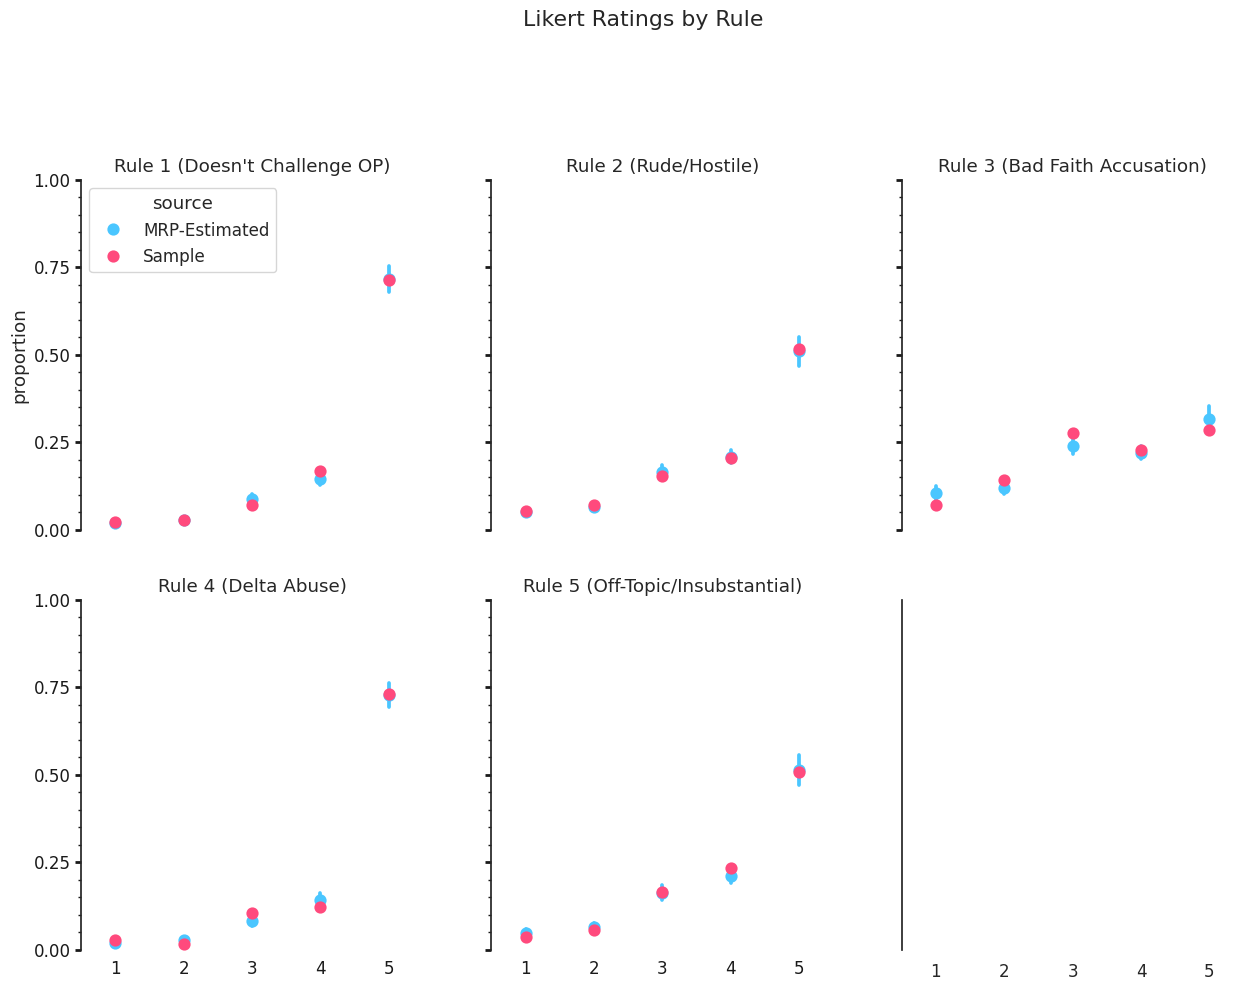

In [ ]:
from support_viz import viz_dist
viz_dist("/content/mrp-adjusted-policy.pdf", gt_proportions, predicted_proportions)

#### Generates figure in A.2.1 in the main paper. ####

4.519163763066202
4.059130434782608
3.5139372822299655
4.509598603839442
4.118260869565217


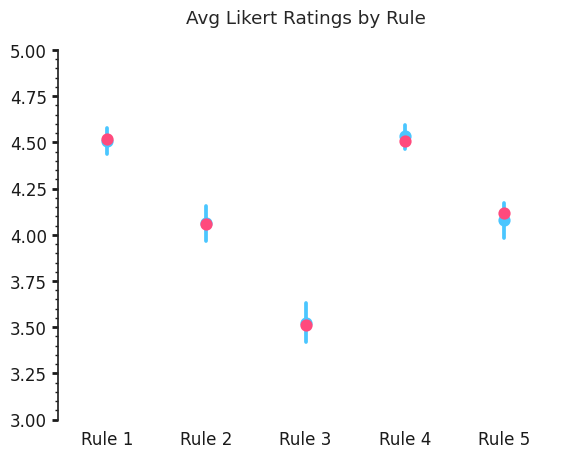

In [ ]:
from support_viz import viz_avg
viz_avg("/content/mrp-adjusted-policy-avg.pdf", gt_proportions, predicted_proportions)